<a href="https://colab.research.google.com/github/hirotaka-i/sandbox/blob/master/PKclusteringPub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PK Analysis

# Mount gdrive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('drive/My Drive/2020/NCNP')
# !ls


# PK parameters analysis

Use the PK parameters created by the other notebook

In [0]:
# activate R magic
%load_ext rpy2.ipython

In [0]:
%%R
install.packages('tableone')
install.packages('PKNCA')
install.packages('gridExtra')

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘gtools’, ‘nloptr’, ‘RcppEigen’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘gdata’, ‘lme4’, ‘survey’, ‘e1071’, ‘zoo’, ‘gmodels’, ‘lmerTest’, ‘labelled’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/gtools_3.8.1.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 187516 bytes (183 KB)

  warnings.warn

In [0]:
%%R
library(tableone)
library(tidyverse)
library(gridExtra)
d= readxl::read_excel('cluster20200116.xlsx', na = "?") # For clustering

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntime

In [0]:
%%R
d %>% summary

   PatientID          Age_exam         Sex             BW(kg)     
 Min.   :1078121   Min.   :20.0   Min.   :0.0000   Min.   :27.90  
 1st Qu.:2489168   1st Qu.:63.0   1st Qu.:0.0000   1st Qu.:46.00  
 Median :2622166   Median :68.0   Median :1.0000   Median :53.40  
 Mean   :2567227   Mean   :67.3   Mean   :0.5375   Mean   :54.25  
 3rd Qu.:2690047   3rd Qu.:73.0   3rd Qu.:1.0000   3rd Qu.:62.00  
 Max.   :2835971   Max.   :89.0   Max.   :1.0000   Max.   :86.00  
                                                   NA's   :1      
      eGFR              Cr         LEDD_PRD2010_    Disease_Duration (years)
 Min.   : 23.25   Min.   :0.4000   Min.   :   0.0   Min.   : 0.000          
 1st Qu.: 61.30   1st Qu.:0.6200   1st Qu.: 100.0   1st Qu.: 3.000          
 Median : 68.70   Median :0.7300   Median : 300.0   Median : 6.000          
 Mean   : 70.25   Mean   :0.7627   Mean   : 366.2   Mean   : 7.667          
 3rd Qu.: 79.11   3rd Qu.:0.8600   3rd Qu.: 550.0   3rd Qu.:11.000          
 M

In [0]:
%%R
d$ID = d$PatientID 
# Check the duplicated ID and remove the second obs
d$ID[duplicated(d$ID)]
d = d[!duplicated(d$ID),]
d = d %>% rename(LD_DOSE = `L-DOPA`) ### Need to change the name

##############################
# Non compartment analysis
##############################
# Data preparation
# install.packages('PKNCA') 
library(PKNCA)
metabs = c('L.DOPA')
# metabs = c('L.DOPA', 'DA', 'DOPAC', 'HVA', '3OMD')
getLong = function(metab){
  keepcols = grep(paste0('^', metab), names(d), value = T)
  # modify data for analysis.
  
  data = d %>% 
    select(c('ID', keepcols)) %>%
    gather(value = 'Conc', key='time', -ID)  %>%
    mutate(Time = case_when(time==keepcols[1] ~ 0,
                            time==keepcols[2] ~ 0.25,
                            time==keepcols[3] ~ 0.5,
                            time==keepcols[4] ~ 1,
                            time==keepcols[5] ~ 2,
                            time==keepcols[6] ~ 3,
                            time==keepcols[7] ~ 4)) %>%
    select(ID, Time, Conc)
  names(data)[3] = paste(metab,'conc', sep="_")
  return(data)
}
dflongs = lapply(metabs, getLong)
dflongAll = plyr::join_all(dflongs, by=c('ID', 'Time'))
names(dflongAll) = gsub('\\.', '-', names(dflongAll))
names(dflongAll) = gsub('ID', 'PatientID', names(dflongAll))
names(dflongAll) = gsub('X3OMD', '3OMD', names(dflongAll))
write.csv(dflongAll, 'analysisSet_long.csv', row.names=F)

In [0]:
%%R
# PK analysis
metabs = c('L.DOPA')
getPKparam = function(dflong){
  data = dflong
  metab = strsplit(names(data)[3], '_')[[1]][1]
  cat(metab)
  names(data)[3] = 'Conc'
  data = data %>%
    mutate(Dose = ifelse(Time==0, 100, 0),
           Cmt = 1,
           Subject = ID) %>%
    arrange(ID, Time)
  # Set the parameters and do the NC analysis
  opt = PKNCA.options('single.dose.aucs')
  opt[1,2] = 4
  PKNCA.options('single.dose.aucs'=opt)
  my.conc = PKNCAconc(data, Conc ~Time|ID + Subject)
  datad = data[data$Dose==100,]
  my.dose = PKNCAdose(datad, Dose ~ Time|ID + Subject)
  my.data = PKNCAdata(my.conc, my.dose)
  my.results = pk.nca(my.data)
  result = summary(my.results)
  
  # Clean the results and create reoprt.csv
  ## convert results into numeric values
  result[,5:9] = result[,5:9] %>% 
    as.matrix() %>% 
    str_extract('[0-9.]+') %>%
    as.numeric()
  auc4h = result %>% 
    filter(!is.na(auclast)) %>%
    rename(auc4h = auclast) %>%
    select(ID, auc4h)
  ncparam = result %>% 
    filter(!is.na(cmax)) %>%
    select(ID, cmax, tmax, half.life, aucinf.obs)
  
  report = inner_join(auc4h, ncparam, by='ID')
  names(report)[-1] = paste(metab, names(report)[-1], sep='_')
  cat(' finish\n')
  return(report)
}

PKparams = lapply(dflongs, getPKparam)
PKparamAll = plyr::join_all(PKparams, by ='ID')
names(PKparamAll) = gsub('\\.', '-', names(PKparamAll))
names(PKparamAll) = gsub('ID', 'PatientID', names(PKparamAll))
names(PKparamAll) = gsub('X3OMD', '3OMD', names(PKparamAll))
write.csv(PKparamAll, 'analysisSet_PKparam.csv', row.names=F)

L.DOPA finish


In [0]:
%%R
# nca levodopa analysis set
dnca1 = inner_join(d[,1:19], PKparamAll[, 1:6], by ='PatientID')
names(dnca1)[-1] = c('Age', 'Sex', 'BW', 'eGFR', 
                     'Cr', 'LEDD_PROD', 'Disease_Duration', 'Diag', 'PK_test_drug',
                     'Dyskinesia', 'cmax_predetermined', 
                     'L-DOPA_0', 'L-DOPA_15', 'L-DOPA_30', 'L-DOPA_60',
                     'L-DOPA_120', 'L-DOPA_180', 'L-DOPA_240',
                     'auc4h', 'cmax', 'tmax',
                     'half.life', 'aucinf')

dnca1$age_at_diagnosis = dnca1$Age-dnca1$Disease_Duration
dnca1$cmax_predetermined = NULL # pre-determined cmax removed. 
dnca1$Cr = NULL
dnca1$Diag = NULL # All PD
dnca1$LEDD_PROD = NULL # undetermined variable

# dnca1 exclude outliers (n=4)
dnca1 = dnca1 %>% 
  filter(age_at_diagnosis>30) %>%
  filter(eGFR<150)

write.csv(dnca1, 'analysisSet_PKparam_levodopa.csv', row.names=F)

In [0]:
%%R
rm(list=ls())

# Clustering 2 KShape

Use time seried clustering based on the shape (tslearn.KShape)

[reference](https://blog.brains-tech.co.jp/entry/tslearn-time-series-clustering)

1. Use L-dopa concentrations
2. Remove test drug == 1
3. Remove the $L-dopa\space conc > bl\_thres$ at the time==0
4. Need to fill every 15 min points: linear interpolations after converting to sqrt of the original values.



In [0]:
!pip install tslearn

     |████████████████████████████████| 532kB 4.9MB/s 
  Created wheel for tslearn: filename=tslearn-0.2.5-cp36-cp36m-linux_x86_64.whl size=816805 sha256=5a7ac24ac2f629e9fbefb741c90fe83e22f9ee11e52e74d10f5f7e42d2f638fc
  Stored in directory: /root/.cache/pip/wheels/1d/6a/f7/145f874cbaebf801a5d89b71197585db9b1ddc72d666236cc3
Successfully built tslearn


In [0]:
 # chronological data clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [0]:
df = pd.read_csv(r"analysisSet_PKparam_levodopa.csv")
print(df.shape)

# skip#################################################
## exclude benserazide
df = df.loc[df['PK_test_drug']==0, :].copy()
print(df.shape)

# exclude samples with L-DOPA_0 is higher than threshold
bl_thres = 0.4
df = df[df['L-DOPA_0']<bl_thres].copy()
print(df.shape)
df = df.reset_index()
# have IDs
IDs = df['PatientID'].astype('str')
metaboconc = ['L-DOPA_0', 'L-DOPA_15', 'L-DOPA_30', 'L-DOPA_60', 
              'L-DOPA_120', 'L-DOPA_180', 'L-DOPA_240']
dfc = df.loc[:, metaboconc]
print(dfc.shape)

(399, 21)
(279, 21)
(270, 21)
(270, 7)


In [0]:
def replaceIntervals(df):
  y = []
  for i in df.index:
    x = df.loc[i, :]
    # square root 
    x = x ** (1/2)
    xnew = pd.Series([x[0],  x[1], x[2], np.nan, x[3], 
           np.nan, np.nan, np.nan, x[4], 
           np.nan, np.nan, np.nan, x[5], 
           np.nan, np.nan, np.nan, x[6]]).interpolate(method='linear').tolist()
    xnew = [i**2 for i in xnew]
    y.append(xnew)
  return(np.stack(y))
dfcNew = replaceIntervals(dfc)

In [0]:
def transform_vector(time_series_array):
    # change to vector
    stack_list = []
    for j in range(len(time_series_array)):
        data = np.array(time_series_array[j])
        data = data.reshape((1, len(data))).T
        stack_list.append(data)
    # make it into 1 dimension
    stack_data = np.stack(stack_list, axis=0)
    return stack_data
stack_data = transform_vector(dfcNew)
# 相互相関を計算するために、正規化する必要があります。
stack_data_beforeNormalization = stack_data
stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(stack_data)

In [0]:
# Check the arrays
# print(dfcNew[1])
# print(stack_data[1])
stack_data.shape

(270, 17, 1)

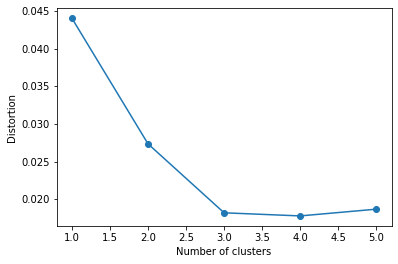

In [0]:
seed = 3
distortions = []
max_cluster = 6
#1~max_clusterクラスタまで計算 
for i in range(1,max_cluster):
    print(i, end='\r')
    ks = KShape(n_clusters=i, n_init=10, verbose=False, random_state=seed)
    #クラスタリングの計算を実行
    try:
      ks.fit(stack_data)
      #ks.fitするとks.inertia_が得られる
      #inertia_でSSEを取得できる
      distortions.append(ks.inertia_)
    except:
      distortions.append(np.nan)

plt.plot(range(1,max_cluster), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.savefig(r"KShapeElbow.png", dpi=600)

1: 129
3: 44
2: 97


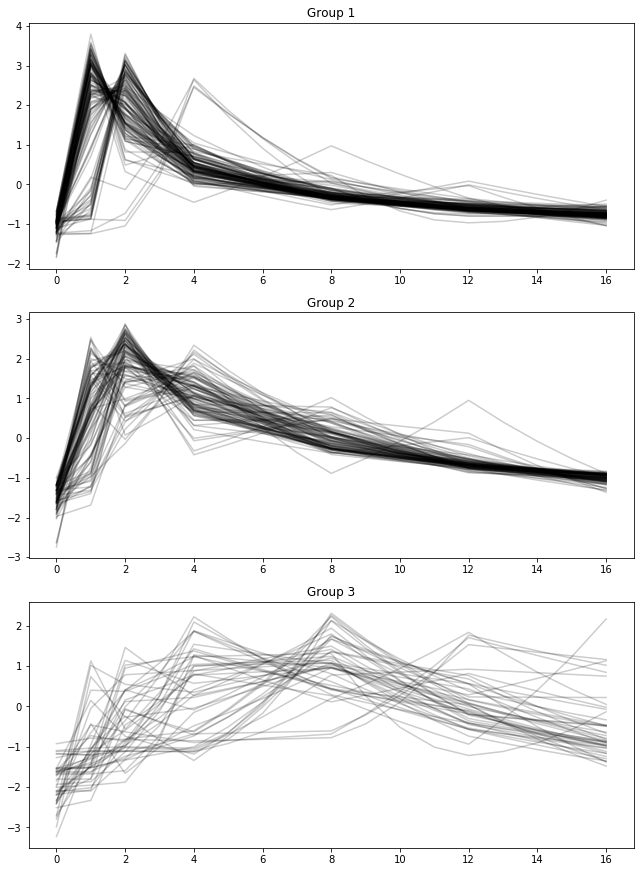

In [0]:
seed = 3

#KShapeクラスのインスタンス化
N_CLUSTERS = 3
ks = KShape(n_clusters=N_CLUSTERS, n_init=30, verbose=False, random_state=seed)
y_pred = ks.fit_predict(stack_data)

#クラスタリングして可視化
plt.figure(figsize=(9,16))
for yi in range(N_CLUSTERS):
    Grp = [1,3,2][yi]
    plt.subplot(N_CLUSTERS+1, 1, Grp)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    #plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Group {Grp}")
    print(f'{Grp}: {(y_pred==yi).sum()}')

plt.tight_layout()
plt.savefig(r"KShape_Normalized.png", dpi=300)
# plt.show()

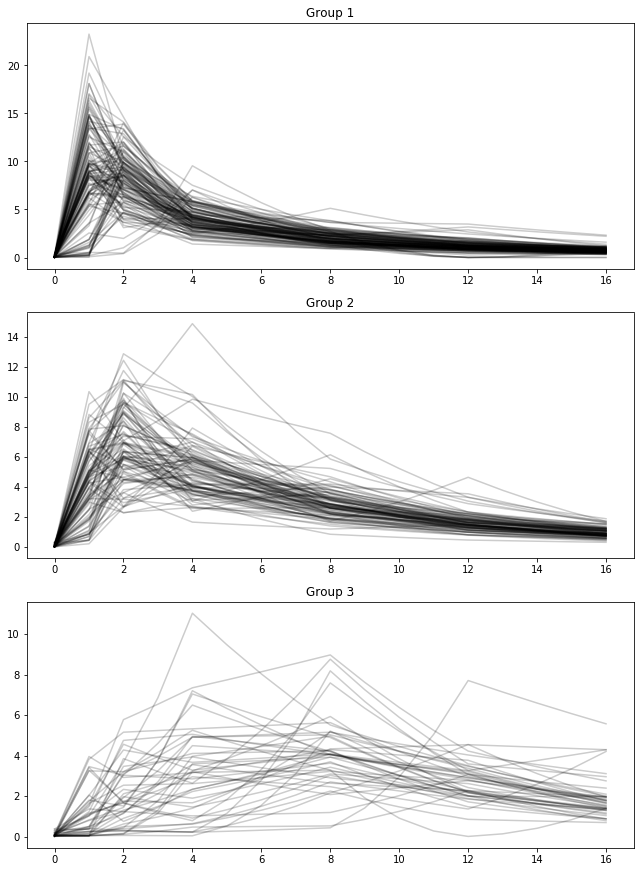

In [0]:
plt.figure(figsize=(9,16))
for yi in range(N_CLUSTERS):
    Grp = [1,3,2][yi]
    plt.subplot(N_CLUSTERS+1, 1, Grp)
    for xx in stack_data_beforeNormalization[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    #plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Group {Grp}")

plt.tight_layout()
plt.savefig(r"KShape_raw.png", dpi=300)
# plt.show()

# Save category

In [0]:
pd.DataFrame(data = {'PatientID':IDs, 'cluster':y_pred}).to_csv(
    r"analysisSetClustered.csv", 
    index=False
)

In [0]:
grp = pd.read_csv(r"analysisSetClustered.csv")
pk = pd.read_csv(r'analysisSet_PKparam_levodopa.csv')
df = pd.concat((iDF.set_index('PatientID') for iDF in [grp, pk]), axis = 1)
df = df[pd.notna(df.cluster)]
df['Group'] = ['Group 1' if i==0
               else 'Group 2' if i==2
               else 'Group 3' for i in df.cluster]
df.to_csv(r'analysisSetResults.csv', index_label='PatientID')

# Tables (Summary and the logistic regression)

In [0]:
%%R
# install.packages('tableone')
# Load data
library(tableone)
library(tidyr)

d = read.csv('analysisSetResults.csv') %>%
  mutate(Dyskinesia = as.factor(Dyskinesia),
    PK_test_drug = as.factor(PK_test_drug),
    Sex = as.factor(Sex), 
    Disease_Duration_cat = case_when(
        Disease_Duration <= 4 ~ '00-04',
        Disease_Duration <= 8 ~ '05-08',
        Disease_Duration <= 12 ~ '09-12',
        Disease_Duration > 12 ~ '12+'),
    DyskinesiaStrata = ifelse(Dyskinesia==1, 'Dyskinesia', 'No Dyskinesia'))
CreateTableOne(vars = 'Disease_Duration_cat', strata = 'DyskinesiaStrata', data=d) %>%
  print(., quote = FALSE, noSpaces = TRUE, printToggle = FALSE) %>%
  write.csv('eTable1.csv')

CreateTableOne(vars=c('Sex', 'Age', 'BW', 'eGFR', 
                      'Disease_Duration', 'Disease_Duration_cat',
                      'Dyskinesia', 'auc4h', 'cmax', 'tmax'),
               strata='Group', 
               data=d) %>%
  print(., quote = FALSE, noSpaces = TRUE, printToggle = FALSE) %>%
  write.csv('Table1.csv')

In [0]:
%%R
mod = glm(Dyskinesia ~ Sex + Age + Group + BW + Disease_Duration_cat + eGFR,
    data=d, family = binomial())
res = coef(summary(mod)) %>% data.frame() %>%add_rownames() %>%
  mutate(M.CI = sprintf('%.2f [%.2f, %.2f]', 
                       exp(Estimate),
                       exp(Estimate - 1.96*Std..Error),
                       exp(Estimate + 1.96*Std..Error)))
res

# A tibble: 10 x 6
   rowname              Estimate Std..Error z.value    Pr...z.. M.CI            
   <chr>                   <dbl>      <dbl>   <dbl>       <dbl> <chr>           
 1 (Intercept)           -0.988      2.73    -0.362     7.18e-1 0.37 [0.00, 78.…
 2 Sex1                   0.529      0.449    1.18      2.38e-1 1.70 [0.70, 4.0…
 3 Age                   -0.0339     0.0232  -1.46      1.43e-1 0.97 [0.92, 1.0…
 4 GroupGroup 2          -0.882      0.398   -2.22      2.67e-2 0.41 [0.19, 0.9…
 5 GroupGroup 3          -0.784      0.519   -1.51      1.31e-1 0.46 [0.17, 1.2…
 6 BW                    -0.0264     0.0215  -1.23      2.20e-1 0.97 [0.93, 1.0…
 7 Disease_Duration_ca…   2.55       0.677    3.76      1.68e-4 12.76 [3.39, 48…
 8 Disease_Duration_ca…   3.89       0.700    5.56      2.77e-8 48.84 [12.39, 1…
 9 Disease_Duration_ca…   4.01       0.688    5.83      5.69e-9 54.99 [14.28, 2…
10 eGFR                   0.0138     0.0127   1.09      2.77e-1 1.01 [0.99, 1.0…


In [0]:
%%R
mod = glm(Dyskinesia ~ Sex + Age + Group + BW + Disease_Duration_cat + eGFR,
    data=d, family = binomial())
res = coef(summary(mod)) %>% data.frame() %>%add_rownames() %>%
  mutate(M.CI = sprintf('%.2f [%.2f, %.2f]', 
                       exp(Estimate),
                       exp(Estimate - 1.96*Std..Error),
                       exp(Estimate + 1.96*Std..Error)))
write.csv(res, 'Table2.csv')
print(res)

# Exchange Group and cmax
mod = glm(Dyskinesia ~ Sex + Age + cmax + BW + Disease_Duration_cat + eGFR,
    data=d, family = binomial())
res = coef(summary(mod)) %>% data.frame() %>%add_rownames() %>%
  mutate(M.CI = sprintf('%.2f [%.2f, %.2f]', 
                       exp(Estimate),
                       exp(Estimate - 1.96*Std..Error),
                       exp(Estimate + 1.96*Std..Error)))
write.csv(res, 'eTable3.csv')
print(res)

# A tibble: 10 x 6
   rowname              Estimate Std..Error z.value    Pr...z.. M.CI            
   <chr>                   <dbl>      <dbl>   <dbl>       <dbl> <chr>           
 1 (Intercept)           -0.988      2.73    -0.362     7.18e-1 0.37 [0.00, 78.…
 2 Sex1                   0.529      0.449    1.18      2.38e-1 1.70 [0.70, 4.0…
 3 Age                   -0.0339     0.0232  -1.46      1.43e-1 0.97 [0.92, 1.0…
 4 GroupGroup 2          -0.882      0.398   -2.22      2.67e-2 0.41 [0.19, 0.9…
 5 GroupGroup 3          -0.784      0.519   -1.51      1.31e-1 0.46 [0.17, 1.2…
 6 BW                    -0.0264     0.0215  -1.23      2.20e-1 0.97 [0.93, 1.0…
 7 Disease_Duration_ca…   2.55       0.677    3.76      1.68e-4 12.76 [3.39, 48…
 8 Disease_Duration_ca…   3.89       0.700    5.56      2.77e-8 48.84 [12.39, 1…
 9 Disease_Duration_ca…   4.01       0.688    5.83      5.69e-9 54.99 [14.28, 2…
10 eGFR                   0.0138     0.0127   1.09      2.77e-1 1.01 [0.99, 1.0…
# A tibbl

In [0]:
%%R
d %>% head

  PatientID cluster Age Sex   BW      eGFR Disease_Duration PK_test_drug
1   1117026       0  68   0 43.6 102.30000                6            0
2   2037147       2  85   1 39.6  67.58128               19            0
3   2061119       0  64   1 54.5  73.31553               15            0
4   2087397       2  71   0 57.2  63.28478               15            0
5   2141649       2  69   1 49.0  94.93330               13            0
6   2149151       2  69   0 63.1  71.50554               17            0
  Dyskinesia L.DOPA_0 L.DOPA_15 L.DOPA_30 L.DOPA_60 L.DOPA_120 L.DOPA_180
1          0  0.02859   2.55392   1.98447   7.02399    1.66911    1.14404
2          0  0.10475   1.37165  10.95821   7.35510    4.35375    1.94706
3          0  0.01758  16.33885   9.70860   5.14779    2.27094    1.20909
4          0  0.09462   0.88591   6.03933   4.09829    2.34397    1.35609
5          1  0.02012   8.62631  11.11455   6.21465    2.82470    1.51466
6          0  0.16573   3.23183   3.19534   2

In [0]:
%%R
mod1 = glm(Dyskinesia ~ Sex + age_at_diagnosis + Group + BW + Disease_Duration_cat + eGFR,
    data=d, family = binomial())
mod2 = glm(Dyskinesia ~ Sex + age_at_diagnosis + BW + Disease_Duration_cat + eGFR,
    data=d, family = binomial())
anova(mod1, mod2, test = 'Chisq')

Analysis of Deviance Table

Model 1: Dyskinesia ~ Sex + age_at_diagnosis + Group + BW + Disease_Duration_cat + 
    eGFR
Model 2: Dyskinesia ~ Sex + age_at_diagnosis + BW + Disease_Duration_cat + 
    eGFR
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1       260     199.97                       
2       262     205.75 -2  -5.7739  0.05575 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Graphs by cluster

In [0]:
%%R
library(tidyr)
substances = c('L.DOPA_conc')
df = read.csv('analysisSet_long.csv') %>%
  arrange(PatientID, Time)

# Square root
df[substances] = sqrt(df[substances])
ymax = max(df[substances])

# Devide clusters
d = read.csv('analysisSetResults.csv')
IDc1 = d$PatientID[d$Group=='Group 1']
IDc2 = d$PatientID[d$Group=='Group 2']
IDc3 = d$PatientID[d$Group=='Group 3']
IDc = list(IDc1, IDc2, IDc3)

pdf('analysisSetClusteredSQRT.pdf', paper = 'a4', width = 8, height = 11)
par(mfrow=c(4,3))
for (k in 1:length(IDc)){
  for (i in 1:length(IDc[[k]])){
    patient_i = IDc[[k]][i] 
    d = df[df$PatientID==patient_i,]
    for (j in 1:length(substances)){
      substance_j = substances[j]
      plot(d$Time, t(d[substance_j]), 
          type='o', col=j, xlab='', ylab='', yaxt='n', ylim =c(0, ymax))
      text(x=d$Time[j+2]-10, y =d[j+2,substance_j], sub('X', '', substance_j), col=j)
      par(new=T)
    }
    subt=paste0('Group', k)
    # if(patient_i %in% c(2641859, 2760168, 2766215, 2796834)){subt = 'outlier'}
    title(paste('PatientID', patient_i, subt))
    par(new=F)
  }
}
dev.off()    


png 
  2 


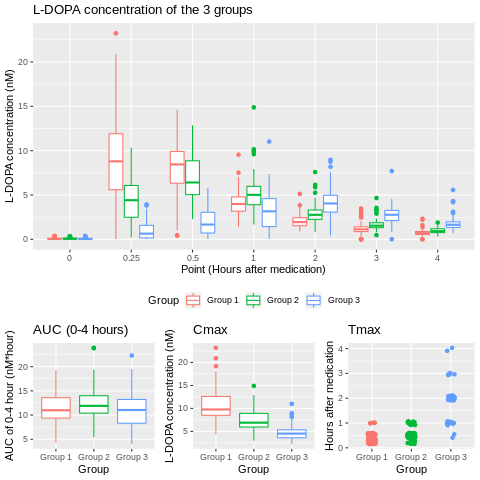

In [0]:
%%R
# install.packages('gridExtra')
# Load data
# Load data
# Fig average concentration of L-DOPA
d = read.csv('analysisSetResults.csv')
  
dl= read.csv('analysisSet_long.csv') %>%
  inner_join(., d, by = 'PatientID') %>%
  mutate(Hour = as.factor(Time))
  
p1 = ggplot(data=dl, aes(Hour, L.DOPA_conc, color=Group)) + 
  geom_boxplot() + 
  theme(legend.position = 'bottom') + 
  ggtitle('L-DOPA concentration of the 3 groups') + 
  xlab('Point (Hours after medication)') + 
  ylab('L-DOPA concentration (nM)') 

# Fig AUC4h
p2 = ggplot(data=d, aes(y=auc4h, x=Group, color=Group)) + 
  geom_boxplot() +
  guides(colour='none') + 
  ggtitle('AUC (0-4 hours)') + 
  xlab('Group') + 
  ylab('AUC of 0-4 hour (nM*hour)') 

# Fig Cmax
p3 = ggplot(data=d, aes(y=cmax, x=Group, color=Group)) + 
  geom_boxplot() +
  guides(colour='none') + 
  ggtitle('Cmax') + 
  xlab('Group') + 
  ylab('L-DOPA concentration (nM)') 

# Fig Tmax
p4 = ggplot(data=d, aes(y=tmax, x=Group, color=Group)) + 
  # geom_boxplot() +
  guides(colour='none') + 
  geom_jitter(width = 0.1) +
  ggtitle('Tmax') + 
  xlab('Group') + 
  ylab('Hours after medication') 

library(gridExtra)
p = grid.arrange(grobs = list(p1, p2, p3, p4),
             width=c(1,1,1), heights = c(2,1),
             layout_matrix = rbind(c(1,1,1), c(2,3,4)))

ggsave(plot=p, width=6, height=6, 
       file='clusterAverage.png', dpi=300)

rm(list=ls())

# Multi-label ROC CV (L-dopa 15 and 30)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp

from sklearn.model_selection import StratifiedKFold


In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [0]:
df = pd.read_csv('analysisSetResults.csv')
IDs = df.PatientID
covs = ['BW','L-DOPA_15', 'L-DOPA_30']
y_temp = df.Group
X = df[covs]

y = label_binarize(y_temp, classes=['Group 1', 'Group 2', 'Group 3'])
n_classes = y.shape[1]

# shuffle and split training and test sets (4, 123)
cv = StratifiedKFold(n_splits=4, shuffle=True)
cv.get_n_splits(X, y_temp)

# Give the returning values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
d_confusion = pd.DataFrame()
for train_index, test_index in cv.split(X, y_temp):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  # Learn to predict each class against the other
  classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
  y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

  # Compute ROC curve and ROC area for each class
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr_i, tpr_i, _ = roc_curve(y_test[:, i], y_score[:, i])
      tpr[i] = interp(mean_fpr, fpr_i, tpr_i)
      tpr[i][0] = 0
      roc_auc[i] = auc(fpr_i, tpr_i)

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr_micro, tpr_micro)
  tpr['micro'] = interp(mean_fpr, fpr_micro, tpr_micro)
  tpr['micro'][0] = 0

  # macro_auc was ommited

  tprs.append(tpr)
  aucs.append(roc_auc)

  # confusion matrix
  d_confusion = d_confusion.append(pd.DataFrame(
    data={'class':y_temp[test_index], 
          'prediction':y_score.argmax(axis=1)+1, 'num':np.ones(y_test.shape[0])}))

In [0]:
# confusion matrix
cmacc = (104+77+34)/d_confusion.shape[0] # BW, LD15, LD30
print(f'accuracy of confusion matrix = {cmacc}')
d_confusion.groupby(['class', 'prediction']).count()

accuracy of confusion matrix = 0.7962962962962963


num
class   prediction     
Group 1 1           104
        2            21
        3             4
Group 2 1            14
        2            77
        3             6
Group 3 2            10
        3            34

In [0]:
# Means and Standard deviations over cross-validation
def getMstd(dic):
  x_mean=dict()
  x_std =dict()
  for k in dic[0].keys():
    x = [i[k] for i in dic]
    x_mean[k] = np.mean(x, axis=0)
    x_std[k] = np.std(x, axis=0)
  return(x_mean, x_std)

mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)
print(mean_auc)

{0: 0.9102244543650793, 1: 0.8868759910147992, 2: 0.9657560093415357, 'micro': 0.9269034664753364}


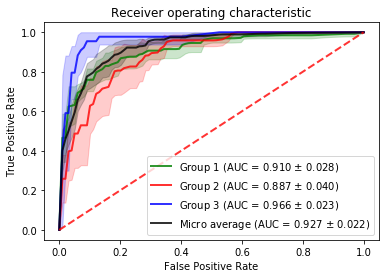

In [0]:
# Graph
colors = {0:'green', 1:'red', 2:'blue', 'micro':'black'}
for k in colors.keys():
  if k=='micro':
    grp = 'Micro average'
  else:
    grp = f'Group {k+1}'
    
  plt.plot(mean_fpr, mean_tpr[k], color=colors[k], 
           label=f'{grp} (AUC = {mean_auc[k]:0.3f} $\pm$ {std_auc[k]:0.3f})',
           lw=2, alpha=.8)
  tprs_upper = np.minimum(mean_tpr[k] + std_tpr[k], 1)
  tprs_lower = np.maximum(mean_tpr[k] - std_tpr[k], 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[k], alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(r'modBoth.png', dpi=600, width=8, height=8)

# L-dopa 15

num
class   prediction     
Group 1 1            97
        2            23
        3             9
Group 2 1            18
        2            69
        3            10
Group 3 1             9
        2            11
        3            24

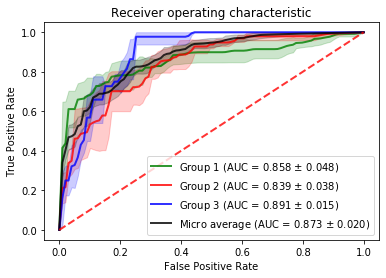

In [0]:
np.random.seed(333)
df = pd.read_csv('analysisSetResults.csv')
IDs = df.PatientID
covs = ['BW','L-DOPA_15']
y_temp = df.Group
X = df[covs]

y = label_binarize(y, classes=['Group 1', 'Group 2', 'Group 3'])
n_classes = y.shape[1]

# shuffle and split training and test sets
cv = StratifiedKFold(n_splits=4, shuffle=True)
cv.get_n_splits(X, y_temp)

# Give the returning values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
d_confusion = pd.DataFrame()
for train_index, test_index in cv.split(X, y_temp):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
  y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

  # Compute ROC curve and ROC area for each class
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr_i, tpr_i, _ = roc_curve(y_test[:, i], y_score[:, i])
      tpr[i] = interp(mean_fpr, fpr_i, tpr_i)
      tpr[i][0] = 0
      roc_auc[i] = auc(fpr_i, tpr_i)

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr_micro, tpr_micro)
  tpr['micro'] = interp(mean_fpr, fpr_micro, tpr_micro)
  tpr['micro'][0] = 0

  # macro_auc was ommited

  tprs.append(tpr)
  aucs.append(roc_auc)

  # confusion matrix
  d_confusion = d_confusion.append(pd.DataFrame(
    data={'class':y_temp[test_index], 
          'prediction':y_score.argmax(axis=1)+1, 'num':np.ones(y_test.shape[0])}))

# Means and Standard deviations over cross-validation
mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Means and Standard deviations over cross-validation
mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Graph
colors = {0:'green', 1:'red', 2:'blue', 'micro':'black'}
for k in colors.keys():
  if k=='micro':
    grp = 'Micro average'
  else:
    grp = f'Group {k+1}'
    
  plt.plot(mean_fpr, mean_tpr[k], color=colors[k], 
           label=f'{grp} (AUC = {mean_auc[k]:0.3f} $\pm$ {std_auc[k]:0.3f})',
           lw=2, alpha=.8)
  tprs_upper = np.minimum(mean_tpr[k] + std_tpr[k], 1)
  tprs_lower = np.maximum(mean_tpr[k] - std_tpr[k], 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[k], alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.savefig(r'modL15.png', dpi=600, width=7, height=7)
d_confusion.groupby(['class', 'prediction']).count()

# L-dopa 30

num
class   prediction     
Group 1 1            87
        2            36
        3             6
Group 2 1            51
        2            36
        3            10
Group 3 1             1
        2            12
        3            31

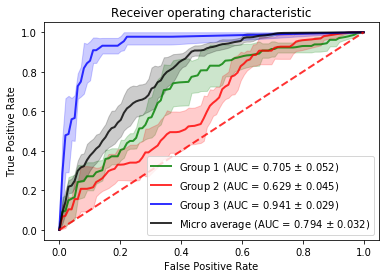

In [0]:
np.random.seed(333)
df = pd.read_csv('analysisSetResults.csv')
IDs = df.PatientID
covs = ['BW','L-DOPA_30']
y_temp = df.Group
X = df[covs]

y = label_binarize(y, classes=['Group 1', 'Group 2', 'Group 3'])
n_classes = y.shape[1]

# shuffle and split training and test sets (4, 123), (3, 123)
cv = StratifiedKFold(n_splits=4, shuffle=True)
cv.get_n_splits(X, y_temp)

# Give the returning values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
d_confusion = pd.DataFrame()
for train_index, test_index in cv.split(X, y_temp):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
  y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

  # Compute ROC curve and ROC area for each class
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr_i, tpr_i, _ = roc_curve(y_test[:, i], y_score[:, i])
      tpr[i] = interp(mean_fpr, fpr_i, tpr_i)
      tpr[i][0] = 0
      roc_auc[i] = auc(fpr_i, tpr_i)

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr_micro, tpr_micro)
  tpr['micro'] = interp(mean_fpr, fpr_micro, tpr_micro)
  tpr['micro'][0] = 0

  # macro_auc was ommited

  tprs.append(tpr)
  aucs.append(roc_auc)

  # confusion matrix
  d_confusion = d_confusion.append(pd.DataFrame(
    data={'class':y_temp[test_index], 
          'prediction':y_score.argmax(axis=1)+1, 'num':np.ones(y_test.shape[0])}))

# Means and Standard deviations over cross-validation
mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Means and Standard deviations over cross-validation
mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Graph
colors = {0:'green', 1:'red', 2:'blue', 'micro':'black'}
for k in colors.keys():
  if k=='micro':
    grp = 'Micro average'
  else:
    grp = f'Group {k+1}'
    
  plt.plot(mean_fpr, mean_tpr[k], color=colors[k], 
           label=f'{grp} (AUC = {mean_auc[k]:0.3f} $\pm$ {std_auc[k]:0.3f})',
           lw=2, alpha=.8)
  tprs_upper = np.minimum(mean_tpr[k] + std_tpr[k], 1)
  tprs_lower = np.maximum(mean_tpr[k] - std_tpr[k], 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[k], alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.savefig(r'modL30.png', dpi=600, width=7, height=7)
d_confusion.groupby(['class', 'prediction']).count()

# Clinical Data only

num
class   prediction     
Group 1 1            76
        2            45
        3             8
Group 2 1            51
        2            36
        3            10
Group 3 1            22
        2            17
        3             5

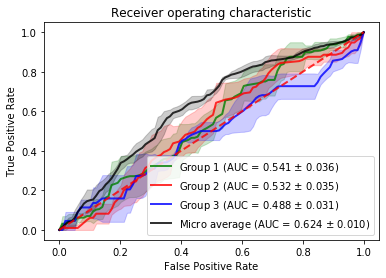

In [0]:
df = pd.read_csv('analysisSetResults.csv')
IDs = df.PatientID
covs = ['Age', 'Sex', 'Dyskinesia', 'BW',  'Disease_Duration']
y_temp = df.Group
X = df[covs]

y = label_binarize(y, classes=['Group 1', 'Group 2', 'Group 3'])
n_classes = y.shape[1]

# shuffle and split training and test sets (4, 123), (3, 123)
cv = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
cv.get_n_splits(X, y_temp)

# Give the returning values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
d_confusion = pd.DataFrame()
for train_index, test_index in cv.split(X, y_temp):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
  y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

  # Compute ROC curve and ROC area for each class
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr_i, tpr_i, _ = roc_curve(y_test[:, i], y_score[:, i])
      tpr[i] = interp(mean_fpr, fpr_i, tpr_i)
      tpr[i][0] = 0
      roc_auc[i] = auc(fpr_i, tpr_i)

  # Compute micro-average ROC curve and ROC area
  fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr_micro, tpr_micro)
  tpr['micro'] = interp(mean_fpr, fpr_micro, tpr_micro)
  tpr['micro'][0] = 0

  # macro_auc was ommited

  tprs.append(tpr)
  aucs.append(roc_auc)

  # confusion matrix
  d_confusion = d_confusion.append(pd.DataFrame(
    data={'class':y_temp[test_index], 
          'prediction':y_score.argmax(axis=1)+1, 'num':np.ones(y_test.shape[0])}))

# Means and Standard deviations over cross-validation
def getMstd(dic):
  x_mean=dict()
  x_std =dict()
  for k in dic[0].keys():
    x = [i[k] for i in dic]
    x_mean[k] = np.mean(x, axis=0)
    x_std[k] = np.std(x, axis=0)
  return(x_mean, x_std)

mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Means and Standard deviations over cross-validation
def getMstd(dic):
  x_mean=dict()
  x_std =dict()
  for k in dic[0].keys():
    x = [i[k] for i in dic]
    x_mean[k] = np.mean(x, axis=0)
    x_std[k] = np.std(x, axis=0)
  return(x_mean, x_std)

mean_tpr, std_tpr = getMstd(tprs)
mean_auc, std_auc = getMstd(aucs)

# Graph
colors = {0:'green', 1:'red', 2:'blue', 'micro':'black'}
for k in colors.keys():
  if k=='micro':
    grp = 'Micro average'
  else:
    grp = f'Group {k+1}'
    
  plt.plot(mean_fpr, mean_tpr[k], color=colors[k], 
           label=f'{grp} (AUC = {mean_auc[k]:0.3f} $\pm$ {std_auc[k]:0.3f})',
           lw=2, alpha=.8)
  tprs_upper = np.minimum(mean_tpr[k] + std_tpr[k], 1)
  tprs_lower = np.maximum(mean_tpr[k] - std_tpr[k], 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[k], alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.savefig(r'modClin.png', dpi=600, width=7, height=7)
d_confusion.groupby(['class', 'prediction']).count()